In [3]:
from google.colab import drive
drive.mount("/content/gdrive/")
!ls "/content/gdrive/My Drive/Sigmoid"

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).
kmnist_classmap.csv   kmnist-train-imgs.npy    Submission.csv
KMNIST.ipynb	      kmnist-train-labels.npy
kmnist-test-imgs.npy  Models


In [4]:
%pylab inline
!pip install pycm livelossplot

from livelossplot import PlotLosses
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torchvision.transforms as transforms

device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")
    
def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = False  ##uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
    torch.backends.cudnn.enabled   = False

    return True

Populating the interactive namespace from numpy and matplotlib
Cuda installed! Running on GPU!


In [0]:
path="/content/gdrive/My Drive/Sigmoid/"
train_data = np.load(path+"kmnist-train-imgs.npy")
test_data = np.load(path+"kmnist-test-imgs.npy")
train_labels = np.load(path+"kmnist-train-labels.npy")
classmap = pd.read_csv(path+"kmnist_classmap.csv")

In [6]:
print("Train Data:", train_data.shape)
print("Test Data:", test_data.shape)
print("Train Labels:", train_labels.shape)

Train Data: (60000, 28, 28)
Test Data: (10000, 28, 28)
Train Labels: (60000,)


In [0]:
# Tensor of training data
X = torch.from_numpy(train_data).float()
# Tensor of training labels
y = torch.from_numpy(train_labels).long()
#  Tensor of test data
X_test = torch.from_numpy(test_data).float()

In [0]:
class CustomTensorDataset(torch.utils.data.Dataset):
    def __init__(self, data, targets, transform=None):
        """
        Args:
            data (Tensor): A tensor containing the data e.g. images
            targets (Tensor): A tensor containing all the labels
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.data = data
        self.targets = targets
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample, label = self.data[idx], self.targets[idx]
        sample = sample.view(1, 28, 28).float()
        if self.transform:
            sample = self.transform(sample)

        return sample, label

In [0]:
def normalise_image(data, mean, std):
  X_norm = data[:].float()
  X_norm = X_norm - mean
  X_norm = X_norm / std
  return X_norm

In [0]:
class mLeNet5(nn.Module):
  def __init__(self):
    super(mLeNet5, self).__init__()
    self.c1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2)
    self.s2 = nn.MaxPool2d(kernel_size=2, stride=2)
    self.c3 = nn.Conv2d(6, 16, kernel_size=5, stride=1)
    self.s4 = nn.MaxPool2d(kernel_size=2, stride=2)
    self.c5 = nn.Linear(16*5*5, 1150)
    self.f6 = nn.Linear(1150, 256)
    self.output = nn.Linear(256, 10)
    self.act = nn.ReLU()
    self.dp = nn.Dropout(0.5)

  def forward(self, x):
    x = self.act(self.c1(x))
    x = self.act(self.s2(x))
    x = self.act(self.c3(x))
    x = self.act(self.s4(x))
    x = x.view(-1, x.size(1)*x.size(2)*x.size(3))
    x = self.act(self.c5(x))
    x = self.dp(x)
    x = self.act(self.f6(x))
    x = self.dp(x)
    return self.output(x)

In [0]:
class LeNet5(nn.Module):
  def __init__(self):
    super(LeNet5, self).__init__()
    # The implementation of the LeNet5 architecture
    self.c1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2)
    self.s2 = nn.MaxPool2d(kernel_size=2, stride=2)
    self.c3 = nn.Conv2d(6, 16, kernel_size=5, stride=1)
    self.s4 = nn.MaxPool2d(kernel_size=2, stride=2)
    self.c5 = nn.Linear(16*5*5, 120)
    self.f6 = nn.Linear(120, 84)
    self.output = nn.Linear(84, 10)
    self.act = nn.ReLU()
    
  def forward(self, x):
    # Applying the ReLU activation function throughout the net
    x = self.act(self.c1(x))
    x = self.act(self.s2(x))
    x = self.act(self.c3(x))
    x = self.act(self.s4(x))
    x = x.view(-1, x.size(1)*x.size(2)*x.size(3))
    x = self.act(self.c5(x))
    x = self.act(self.f6(x))
    return self.output(x)

In [0]:
	
class SupervisedLearning:
    def __init__(self, X, y, model, optimiser, loss_function, batch_size, test_batch_size,
                 device="cpu", 
                 confusion_matrix=True, 
                 train_transform=None,
                 val_transform=None, 
                 seed=42, n_epochs=30,
                 val_ratio=0.1, n_splits=1, 
                 early_stop = True,
                 patience = None,
                 tol = None):
      """
      
      """
      
      self.device = device
      
      self.X = X.float()/255.
      self.y = y
      
      self.model = model.to(self.device)
      self.optimiser = optimiser
      self.loss_function = loss_function
      
      self.X_train = None
      self.X_val = None
      
      self.y_train = None
      self.y_val = None
      
      self.train_transform = train_transform
      self.val_transform = val_transform
      
      assert(batch_size > 0 and batch_size < int(0.1 * X.size()[0]))
      self.batch_size = batch_size
      assert(test_batch_size > 0 and test_batch_size < int(0.1 * X.size()[0]))
      self.test_batch_size = test_batch_size
      self.n_epochs = n_epochs
      self.seed = seed
      self.val_ratio = val_ratio
      self.n_splits = n_splits

      self.trained_full=False
      
      self.mean_full = None
      self.std_full = None
      
      self.mean = None
      self.std = None
      
      self.logs = None 
      
      self.best_model = None
      
      self.early_stop = early_stop
      if self.early_stop: self.early =  early_stopping(patience=patience, rel_tol=tol)  
      
      
    def split_data(self):
      sss = StratifiedShuffleSplit(n_splits=self.n_splits, test_size=self.val_ratio, random_state=0)
      sss.get_n_splits(self.X, self.y)

      for train_index, val_index in sss.split(self.X, self.y):
        self.X_train, self.X_val = self.X[train_index], self.X[val_index]
        self.y_train, self.y_val = self.y[train_index], self.y[val_index]
        
      return None
      
      
      
    def train(self, train_data_loader):
      self.model.train()                # set model to train mode
      
      train_loss, train_accuracy = 0., 0.
      
      for Xtr, ytr in train_data_loader:# X and y are data inside a batch specified
                                        # at train_data_loader
        Xtr = Xtr.to(self.device)
        ytr = ytr.to(self.device)
        
        self.optimiser.zero_grad()           # reset gradients
        zn = self.model(Xtr)                 # perform forward pass
        
        loss = self.loss_function(zn, ytr)   # compute loss value over batch
        loss.backward()                 # perform backward pass
        train_loss += (loss * Xtr.size()[0]).detach().cpu().numpy()
        

        y_pred = F.log_softmax(zn, dim=1).max(1)[1]
        train_accuracy += accuracy_score(ytr.cpu().numpy(), y_pred.detach().cpu().numpy())*Xtr.size()[0]
        
        self.optimiser.step()               # optimisation step
        
      return train_loss/len(train_data_loader.dataset), train_accuracy/len(train_data_loader.dataset)
    
    
    
    def validate(self, val_data_loader):
      self.model.eval()                     # set model to evaluation mode
      
      validation_loss, validation_accuracy = 0., 0.
      
      for Xv, yv in val_data_loader:
        with torch.no_grad():
          
          Xv, yv = Xv.to(self.device), yv.to(self.device)
          
          zn = self.model(Xv)
          loss = self.loss_function(zn, yv)
          validation_loss += (loss * Xv.size(0)).detach().cpu().numpy()
          
          y_pred = F.log_softmax(zn, dim=1).max(1)[1]
          validation_accuracy += accuracy_score(yv.cpu().numpy(), y_pred.detach().cpu().numpy())*Xv.size(0)

            
      return validation_loss/len(val_data_loader.dataset), validation_accuracy/len(val_data_loader.dataset)
        
      
    
    def train_wrapper(self, train_full=False, plot_loss=True):
      # start timer
      t = time.time()
      
      # set seed
      set_seed(int(self.seed))
      
      
      if train_full: # train with full data (train + validation)
        # find mean and std of training data
        mean, std = self.find_mean_std(train_full)
        
        # create dataloaders
        train_dataset = CustomTensorDataset(normalise_image(self.X, mean, std), self.y, transform=self.train_transform)
        train_data_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
        
        best_train_acc = 0
        
        # train and validate
        if plot_loss: liveloss = PlotLosses()
        for epoch in range(self.n_epochs):
            logs = {}
            train_loss, train_accuracy = self.train(train_data_loader)

            if plot_loss:
              logs['' + 'log loss'] = train_loss.item()
              logs['' + 'accuracy'] = train_accuracy.item()
              logs['val_' + 'log loss'] = 1.
              logs['val_' + 'accuracy'] = 1.
              liveloss.update(logs)
              liveloss.draw()
              
            # Checking stopping criteria
            if self.early_stop: self.early(train_accuracy)
                
            # Saving the best weights    
            if train_accuracy.item() > best_train_acc:  
              # Saving the models weights to best model
              self.best_model = self.model
              best_train_acc = train_accuracy.item()
            
            # If the stopping criteria is met  
            if self.early.stop: 
                self.model = self.best_model
                break
                
        self.trained_full=True
        self.logs = liveloss

      else:
        # split data
        self.split_data()
        
        # find mean and std of training data
        mean, std = self.find_mean_std(train_full)
        
        
        # create dataloaders

        train_dataset = CustomTensorDataset(normalise_image(self.X_train, mean, std), self.y_train, transform=self.train_transform)
        train_data_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
        
        val_dataset = CustomTensorDataset(normalise_image(self.X_val, mean, std), self.y_val, transform=self.val_transform)
        val_data_loader = DataLoader(val_dataset, batch_size=self.test_batch_size, shuffle=False)
        
        best_val_acc = 0
            
        # train and validate
        if plot_loss: liveloss = PlotLosses()
        for epoch in range(self.n_epochs):
            logs = {}
            train_loss, train_accuracy = self.train(train_data_loader)
            val_loss, val_accuracy = self.validate(val_data_loader)
            
            if plot_loss:
              logs['' + 'log loss'] = train_loss.item()
              logs['' + 'accuracy'] = train_accuracy.item()
              logs['val_' + 'log loss'] = val_loss.item()
              logs['val_' + 'accuracy'] = val_accuracy.item() # liveloss wants it plotted
              liveloss.update(logs)
              liveloss.draw() 
            
            # Checking stopping criteria
            if self.early_stop: self.early(val_accuracy)
                
            # Saving the best weights    
            if val_accuracy.item() > best_val_acc:  
              self.best_model = self.model
              best_val_acc = val_accuracy.item()
            
            # If the stopping criteria is met  
            if self.early.stop: 
                self.model = self.best_model
                break

        self.logs = logs
        self.trained_full=False
        self.model = self.best_model
              
      return time.time() - t
            
            
    def evaluate_batch(self, X_test, y_test, confusion_matrix=True, test_transform=None):
      """
      This method performs the same as validate but also returns all predictions on a given dataset
      for a trained model.
      """
      self.model.eval()
      
      test_dataset = CustomTensorDataset(X_test, y_test, transform=test_transform)
      test_data_loader = DataLoader(test_dataset, batch_size=self.test_batch_size, shuffle=True)
      
      ys, y_preds = [], []
      for X, y in test_data_loader:
          with torch.no_grad():
              X, y = X.to(self.device), y.to(self.device)
              a2 = self.model(X)
              y_pred = F.log_softmax(a2, dim=1).max(1)[1]
              ys.append(y.cpu().numpy())
              y_preds.append(y_pred.cpu().numpy())
            
      y_preds, ys =  np.concatenate(y_preds, 0),  np.concatenate(ys, 0)
      
      test_loss, test_accuracy = self.validate(test_data_loader)
      
      if confusion_matrix:
        cm = ConfusionMatrix(actual_vector=ys, predict_vector=y_preds)
        print(cm)
        
        
      return y_preds, ys, test_loss, test_accuracy
    
    
    def get_hyperparameters(self):
      """
      Returns a dictiorary with the follwing hyperparameters:
      
      """
      
      return None
    
    
    def find_mean_std(self, full_training=False):
      """
      Finds the mean and std values of a normalised image (divided by 255)
      """
      mean = 0
      std = 0
      
      if full_training:
        mean = torch.mean(self.X)
        std = torch.std(self.X)
        
        self.mean_full = mean
        self.std_full = std
        
      else:
        mean = torch.mean(self.X_train)
        std = torch.std(self.X_train)
        self.mean = mean
        self.std = std
        
      return mean, std

In [0]:
class early_stopping:
  """
  Counter to implement early stopping
  If validation accuracy has not relative improved above
  a absolute tolerance set by the user than it breaks the 
  training
  If rel_tol is set to 0 it becomes a common counter
  """
  def __init__(self, patience, rel_tol, verbose=True):

    
    self.patience = patience
    self.rel_tol = rel_tol
    self.verbose = verbose
    self.best_score = 0
    self.counter = 0
    self.stop = False

  
  def __call__(self, score):
    
    # If the score is under the required relative tolerance
    # increase the counter is incremented
    if score < self.best_score * (1 + self.rel_tol):
        self.counter += 1
    else:
        self.counter = 0
        
    if score > self.best_score:
      self.best_score = score
      
    if self.counter >= self.patience:
      self.stop = True    
      
    if self.verbose:
      print("Count:", self.counter)

In [0]:
def model_save(model, name, path, val_score):
  """Saving function to keep track of models"""
  val = str(val_score)[2:5]
  path = path + name + '_' + val + '.pth'
  print("Saving model under:", path)
  torch.save(model, path)
  return


def model_load(path, model_name):
  """Loading function for models from google drive"""
  model = torch.load(path + model_name + '.pth')
  return model

In [0]:
def hyperparam_save():
  
  [Model,	Optimiser,	Loss_Function, Early_Stop, Tol, Epochs	Learning_Rate, Momentum, Weight_Decay, Folds,	Data_Augmentation, Val_Acc	Val_Loss	Training_Time (w/ validation)

In [0]:
# Hyperparameters
lr = 1e-2
momentum = 0.5
batch_size = 64
test_batch_size = 1000
n_epochs = 30

model_aug = LeNet5()
optimiser_aug = torch.optim.SGD(model_aug.parameters(), lr=lr, momentum=momentum)
loss_function_aug = nn.CrossEntropyLoss()

train_transform =  transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(10,10,10),
    transforms.RandomCrop(28, pad_if_needed=True),
#     transforms.RandomAffine(10, scale=(1,2), shear=5),
    transforms.ToTensor(), 
])

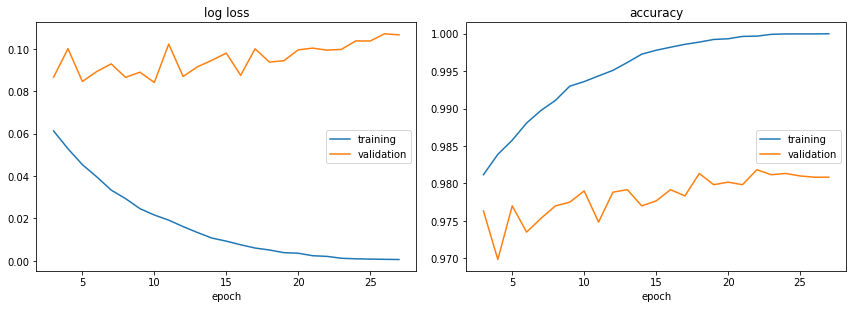

log loss:
training   (min:    0.001, max:    0.081, cur:    0.001)
validation (min:    0.084, max:    0.113, cur:    0.107)

accuracy:
training   (min:    0.975, max:    1.000, cur:    1.000)
validation (min:    0.966, max:    0.982, cur:    0.981)
Count: 5
372.091894865036


In [48]:
learning_aug = SupervisedLearning(X, y, model_aug, optimiser_aug, loss_function_aug, batch_size, test_batch_size,
                 device="cpu", 
                 confusion_matrix=True, 
                 train_transform=None,
                 val_transform=None, 
                 seed=42, n_epochs=n_epochs,
                 val_ratio=0.1, n_splits=1, 
                 early_stop = True,
                 patience = 5,
                 tol = 0.000)


t_aug = learning_aug.train_wrapper(train_full=False)
print(t_aug)

In [0]:
class ensemble_net(nn.Module):
    """A classifier class that takes individiual pretrained models 
    and aggregates their output values to create ensemble voting
      Params
    ------
      models: a list of model objects

    Returns
    -------
      x_out: a probability vector for the output classes
    """
    def __init__(self, models):
        super(ensemble_net, self).__init__()

        self.models = models
        self.soft = nn.Softmax(dim=1)


    def forward(self, x):
        num = len(self.models)

        for ind, model in enumerate(self.models):
          if ind ==0:
            x1 = model(x)
            x_out = self.soft(x1)

          else:
            x1 = model(x)
            x_out += self.soft(x1)

        x_out /= num
        return x_out

    def inspect(self):
      """Returns the composition of the ensemble model"""
      for model in self.models:
        print(model)
      return None

In [0]:
 def evaluate(X_test, model, norm_mean, norm_std, y_val = None, test_batch_size=30, test_transform=None, device="cpu", ensemble=False, save_to_csv=False, path="./foo.csv"):
      """
      This method takes a tensor of images and a trained model and returns the predicted labels
      from those images
      Params
      ------
        X_test: torch.tensor of size (no_images, 28, 28), test images dataset
        model: nn.Module or inherited class object
        test_batch_size: int, defines the size of the batch for the datset
        test_transform: transforms.Compose list of transforms to apply to the dataset
        device: str, on which device to run the model
        save_to_csv: bool, option to save predictions to csv in format (index, prediction)
        path: str, path to save string 
        
      Returns
      -------
        y_preds: np.array of predictios made on X_test by the trained model
        
      """
      model.eval()
      model.to(device)
      y_test = torch.zeros_like(X_test)
      
      # The validation set has already been normalized
      if type(y_val) != None: 
        test_dataset = CustomTensorDataset(X_test, y_test, transform=test_transform)
      else:
        test_dataset = CustomTensorDataset(normalise_image(X_test/255., norm_mean, norm_std), y_test, transform=test_transform)
        
      test_data_loader = DataLoader(test_dataset, test_batch_size, shuffle=False)
      
      y_preds = []
      for X, y in test_data_loader:
          with torch.no_grad():
              X, y = X.to(device), y.to(device)
              a2 = model(X)
              if ensemble: y_pred = a2.max(1)[1]
              else: y_pred = F.log_softmax(a2, dim=1).max(1)[1]
              y_preds.append(y_pred.cpu().numpy())
      y_preds =  np.concatenate(y_preds, 0)
      
#       if type(y_val) != None: print("Validation Accuracy:", len(np.where((y_preds==y_val.numpy())==True)[0])/len (y_preds))
        
      sub = pd.DataFrame(data={'Category': y_preds})
      sub.index.name = "Id" 
      if save_to_csv:
        sub.to_csv(path)
        
      return y_preds, sub

In [0]:
def quick_val_check(y_preds, y):
  """Returns the accuracy on the validation set"""
  return len(np.where((y_preds==y.numpy())==True)[0])/len (y_preds)

In [131]:
# Saving the model
model_save(learning_aug.model, "lenet5", path + "Models/", learning_aug.logs["val_accuracy"])

Saving model under: /content/gdrive/My Drive/Sigmoid/Models/lenet5_980.pth


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type LeNet5. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [235]:
print(X.shape)
print(learning_aug.X_val.shape)
print(learning_aug.y_val)
print(y_preds_ens[:20])
print(learning_aug.y_val[:20])

print(torch.mean(X))
print(torch.mean(X_test))
print(torch.mean(learning_aug.X_val))

torch.Size([60000, 28, 28])
torch.Size([6000, 28, 28])
tensor([8, 6, 6,  ..., 3, 2, 1])
[6 6 6 1 5 4 4 5 0 1 8 5 0 0 4 0 1 4 0 5]
tensor([8, 6, 6, 1, 5, 4, 4, 5, 0, 1, 8, 5, 0, 0, 4, 0, 1, 4, 0, 5])
tensor(48.9312)
tensor(47.0620)
tensor(0.1922)


In [196]:
print("Ensemble:", quick_val_check(y_preds_ens, y))
print("Ensemble:", quick_val_check(y_preds_ens, learning_aug.y_val))

Ensemble: 0.9961
Ensemble: 0.0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until


In [0]:
# ens = ensemble_net([model_lenet_rot10_jitt_979, model_lenet5_958, model_lenet5_980])
# print(ens.inspect())

In [210]:
# y_preds_ens, df = evaluate(X, ens, learning_aug.mean, learning_aug.std, ensemble=True)
y_preds_ens, df = evaluate(learning_aug.X_val, ens, learning_aug.mean, learning_aug.std, y_val = learning_aug.y_val, ensemble=True)

Validation Accuracy: 0.9753333333333334


In [0]:

model = torch.load("/content/gdrive/My Drive/Sigmoid/Models/lenet_drop_aug_986.pth")

In [234]:
model_lenet_rot10_jitt_979 = model_load(path + "Models/", model_name="lenet_rot10_jitt_979")
model_lenet5_980 = model_load(path + "Models/", model_name="/lenet5_980")
model_lenet_drop_aug_986 = model_load(path + "Models/", model_name="lenet_drop_aug_986")

ens = ensemble_net([model_lenet_rot10_jitt_979, model_lenet_drop_aug_986, model_lenet5_980])

y_preds_ens, df =  evaluate(learning_aug.X_val, ens, learning_aug.mean, learning_aug.std, y_val=learning_aug.y_val, ensemble=True, save_to_csv=False, path="")

Validation Accuracy: 0.976


In [0]:
model_lenet_drop_aug_986 = model_load(path + "Models/", model_name="lenet_drop_aug_986")


In [263]:
# print(len(np.where(y_preds_sub==3)))/
print(len(y_preds_sub))
print(len(np.where(y_preds_sub == 3)[0]))

10000
1009


In [0]:
y_preds_sub, df = evaluate(X_test, model_lenet_drop_aug_986, learning_aug.mean, learning_aug.std, ensemble=False, save_to_csv=True, path="/content/gdrive/My Drive/Sigmoid/Models/Submission_3.csv")

In [0]:
# Examples of save and load functionality
model_poor = model_load(path + "Models/", model_name="lenet5_920" )
model_good = model_load(path + "Models/", model_name="lenet5_958" )
model_new = learning_aug.model

ens = ensemble_net([model_poor, model_good, model_new])
# ens.inspect()

In [46]:
# Comparing the performance of various models and then the ensemble of those models
y_preds_good, df = evaluate_test(X, model_poor, learning_aug.mean, learning_aug.std, ensemble=False, save_to_csv=False, path="")
y_preds_poor, df = evaluate_test(X, model_good, learning_aug.mean, learning_aug.std, ensemble=False, save_to_csv=False, path="")
y_preds_new, df = evaluate_test(X, model_new, learning_aug.mean, learning_aug.std, ensemble=False, save_to_csv=False, path="")
y_preds_ens, df = evaluate_test(X, ens, learning_aug.mean, learning_aug.std, ensemble=True, save_to_csv=False, path="")

print("Model 1:", quick_val_check(y_preds_good, y))
print("Model 2:", quick_val_check(y_preds_poor, y))
print("Model 3:", quick_val_check(y_preds_new, y))
print("Ensemble:", quick_val_check(y_preds_ens, y))

Model 1: 0.9228
Model 2: 0.9672
Model 3: 0.9679
Ensemble: 0.9703833333333334


   index codepoint char
0      0    U+304A    お
1      1    U+304D    き
2      2    U+3059    す
3      3    U+3064    つ
4      4    U+306A    な
5      5    U+306F    は
6      6    U+307E    ま
7      7    U+3084    や
8      8    U+308C    れ
9      9    U+3092    を


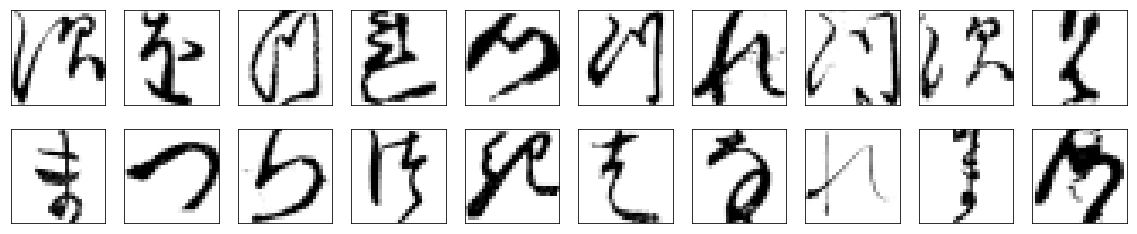

In [248]:
print(classmap)

# for i in range(10):
#   print(y_preds[i], classmap["char"].iloc[y_preds[i]])
plt.figure(figsize=(20,4))
  
for i in range(20):
    plt.subplot(2,10,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_test[i], cmap=plt.cm.binary)
#     plt.xlabel(y_preds[i])